We will ge predicting the solbuility of drug molecules using RNN. We’ll use a GRU to encode the SMILES string into a vector and then apply a dense layer to get a scalar value for solubility. We will use the solubility AqSolDB dataset. It has about 10,000 unique compounds with measured solubility in water (label) and their SMILES strings

In [1]:
# Importing libraries and dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

soldata = pd.read_csv(
    "/content/curated-solubility-dataset.csv"
)
features_start_at = list(soldata.columns).index("MolWt")
np.random.seed(0)

In [2]:
soldata.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


We’ll extract our labels and convert SMILES into padded characters. We make use of a tokenizer, which is essentially a look-up table for how to go from the characters in a SMILES string to integers. To make our model run faster, we will filter out very long SMILES strings.

In [3]:
# filter out long smiles
smask = [len(s) <= 96 for s in soldata.SMILES]
print(f"Removed {soldata.shape[0] - sum(smask)} long SMILES strings")
filtered_soldata = soldata[smask]

# make tokenizer with 128 size vocab and
# have it examine all text in dataset
vocab_size = 128
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    vocab_size, filters="", char_level=True
)
tokenizer.fit_on_texts(filtered_soldata.SMILES)

Removed 285 long SMILES strings


In [4]:
# now we get padded sequences
seqs = tokenizer.texts_to_sequences(filtered_soldata.SMILES)
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, padding="post")

# Now we build dataset
data = tf.data.Dataset.from_tensor_slices((padded_seqs, filtered_soldata.Solubility))

# we split into val, test, train and batch
N = soldata.shape[0]
split = int(0.1 * N)
test_data = data.take(split).batch(16)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(16), nontest.skip(split).shuffle(
    1000
).batch(16)

We will just use an embedding then RNN and some dense layers to get to a final predicted solubility.

In [5]:
model = tf.keras.Sequential()

# we make embedding and indicate that 0 should be treated as padding mask
model.add(
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=16, mask_zero=True)
)

# RNN layer (we use GRU)
model.add(tf.keras.layers.GRU(32))
# a dense hidden layer
model.add(tf.keras.layers.Dense(32, activation="relu"))
# regression, so no activation needed
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          2048      
                                                                 
 gru (GRU)                   (None, 32)                4800      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7937 (31.00 KB)
Trainable params: 7937 (31.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now we’ll compile our model and train it. This is a regression problem, so we use mean squared error for our loss.

In [6]:
model.compile(tf.optimizers.Adam(1e-2), loss="mean_squared_error")
result = model.fit(train_data, validation_data=val_data, epochs=25, verbose=0)

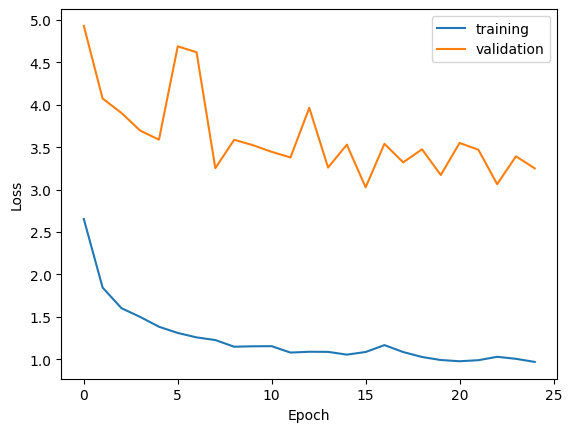

In [7]:
plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [8]:
# Let's see how the test data looks

# evaluate on test data
yhat = []
test_y = []
for x, y in test_data:
    yhat.extend(model(x).numpy().flatten())
    test_y.extend(y.numpy().flatten())
yhat = np.array(yhat)
test_y = np.array(test_y)

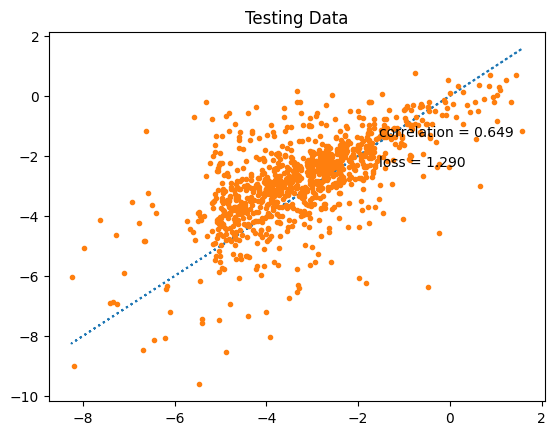

In [9]:
# plot test data
plt.plot(test_y, test_y, ":")
plt.plot(test_y, yhat, ".")
plt.text(min(y) + 1, max(y) - 2, f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}")
plt.text(min(y) + 1, max(y) - 3, f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}")
plt.title("Testing Data")
plt.show()